Links:


*   https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795



(0.0, 2.0, 0.0, 1.0)

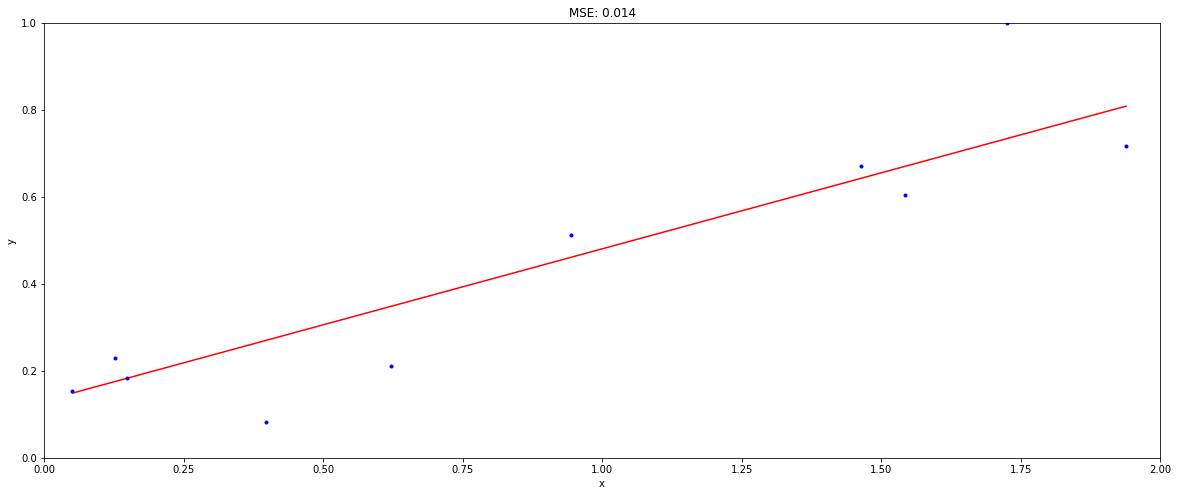

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def make_linear_dataset():
  X = 2*np.random.rand(100,1)
  y = 4 + 3*X + np.random.randn(100,1)
  y = MinMaxScaler().fit_transform(y)
  return X, y


class OLSRegression:
  def fit(self, X, y):
    X1 = np.c_[np.ones((X.shape[0])), X]
    self.W = np.linalg.inv(X1.T @ X1) @ X1.T @ y
    return self

  def predict(self, X):
    X1 = np.c_[np.ones((X.shape[0])), X]
    return X1 @ self.W


np.random.seed(42)

X, y = make_linear_dataset()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1)

# let's sort for plotting
valid_data = list(zip(X_valid, y_valid))
valid_data_sorted = sorted(valid_data, key=lambda t: t[0][0])
X_valid = np.array([x[0] for x in valid_data_sorted])
y_valid = np.array([x[1] for x in valid_data_sorted])

# OLS model for comparing with our Dense network
ols_model = OLSRegression().fit(X_train, y_train)
y_pred = ols_model.predict(X_valid)

test_mse = round(mean_squared_error(y_valid, y_pred), 3)

plt.figure(figsize=(20, 8))
plt.plot(X_valid, y_pred, 'r-')
plt.plot(X_valid, y_valid, 'b.')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'MSE: {test_mse}')
plt.axis([0,2,0,1])

In [2]:
sigmoid = lambda z: 1/(1+np.exp(-z))
d_sigma = lambda z : np.cosh(z/2)**(-2) / 4

class DenseNeuralNetwork:
  
  def __init__(self, nn_layers):
    self.nn_layers = nn_layers
    self._cache = {}
    self._grads = {}
    self.__init_params_rand()
    

  def __init_params_rand(self, seed=42):
    np.random.seed(seed)
    self.params_values = {}

    for idx, layer in enumerate(self.nn_layers):
      # we number layers from 1, to index input as a0
      layer_idx = idx + 1 
      layer_input_size = layer["input_dim"]
      layer_output_size = layer["output_dim"]
      
      self.params_values['w' + str(layer_idx)] = np.random.randn(
          layer_output_size, layer_input_size) * 0.1
        
      self.params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1    
  
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x, keep_cache=True):
    # cache for backward step
    if keep_cache:
      self._cache.clear()
    
    a = x.T

    for idx, layer in enumerate(self.nn_layers):
      layer_idx = idx + 1
      a_prev = a

      w = self.params_values['w' + str(layer_idx)]
      b = self.params_values['b' + str(layer_idx)]
      z = w @ a_prev + b
      a = sigmoid(z)
      if keep_cache:
        self._cache['a' + str(layer_idx-1)] = a_prev
        self._cache['z' +str(layer_idx)] = z
    # Transpose back
    a = a.T
    return a
  
  def backward(self, loss):
    self._grads.clear()

    loss = loss.T
    num_samples = loss.shape[1]
    da_prev = loss  
    
    for idx, layer in reversed(list(enumerate(self.nn_layers))):
      layer_idx = idx + 1 
      da = da_prev

      a_prev = self._cache['a' + str(layer_idx-1)] 
      z = self._cache['z' + str(layer_idx)]
      w = self.params_values['w' + str(layer_idx)]
      
      dz = da * d_sigma(z) 
      dw = dz @ a_prev.T / num_samples
      db = np.sum(dz, axis=1, keepdims=True) / num_samples
      da_prev = w.T @ dz
      #print(db, dw)
      self._grads['dw' + str(layer_idx)] = dw
      self._grads['db' + str(layer_idx)] = db


  def optimizer_step(self, lr):
    for layer_idx, layer in enumerate(self.nn_layers, 1):
      self.params_values['w' + str(layer_idx)] -= lr * self._grads['dw' + str(layer_idx)]
      self.params_values['b' + str(layer_idx)] -= lr * self._grads['db' + str(layer_idx)]

{'a0': array([[0.74908024, 1.90142861]]), 'z1': array([[ 0.01379254,  0.07103131],
       [-0.0337708 , -0.04970367],
       [ 0.20643835,  0.28107463],
       [ 0.19083063,  0.36633673]]), 'a1': array([[0.50344808, 0.51775037],
       [0.4915581 , 0.48757664],
       [0.55142708, 0.56980966],
       [0.5475634 , 0.59057351]]), 'z2': array([[-0.02382516, -0.02756762]])}
(2, 1)
(2, 1)


(0.0, 2.0, 0.0, 1.0)

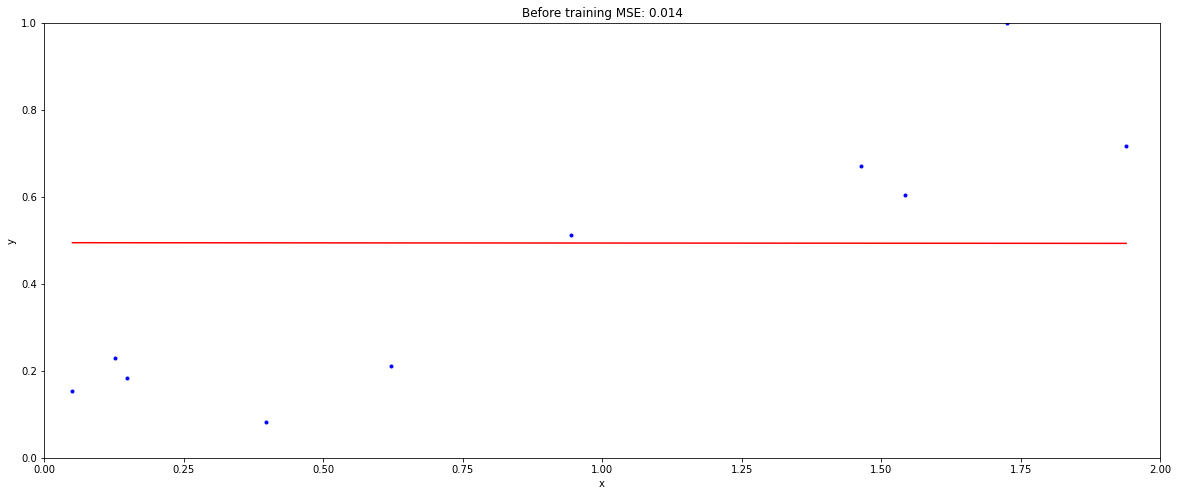

In [3]:
nn_layers = [
    {"input_dim": 1, "output_dim": 4},
    {"input_dim": 4, "output_dim": 1},
]

model = DenseNeuralNetwork(nn_layers)
model.params_values

predict = model(X[:2])
print(model._cache)
print(X[:2].shape)
print(predict.shape)

y_pred = model(X_valid)

valid_mse = round(mean_squared_error(y_valid, y_pred), 3)

plt.figure(figsize=(20, 8))
plt.plot(X_valid, y_pred, 'r-')
plt.plot(X_valid, y_valid, 'b.')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Before training MSE: {test_mse}')
plt.axis([0,2,0,1])

In [4]:
def train(model, epochs, X_train, X_valid, y_train, y_valid, lr):
  best_mse_val = 1
  for epoch in range(epochs):
    y_pred = model(X_train)
    losses = 2*(y_pred - y_train)
    model.backward(losses)
    model.optimizer_step(lr)
    train_mse = round(mean_squared_error(y_train, y_pred), 3)
    
    y_pred = model(X_valid)
    valid_mse = round(mean_squared_error(y_valid, y_pred), 3)

    if valid_mse < best_mse_val:
      best_mse_val = valid_mse

    if epoch % 100 == 0:  
      print(f'Epoch: {epoch}, Train MSE:{train_mse}, Valid MSE:{valid_mse}, Best Valid MSE:{best_mse_val}')

epochs = 1000
lr = 10 # so big because data is normalized

nn_layers = [
    {"input_dim": 1, "output_dim": 8},
    {"input_dim": 8, "output_dim": 1},
]

model = DenseNeuralNetwork(nn_layers)
train(model, epochs, X_train, X_valid, y_train, y_valid, lr)

Epoch: 0, Train MSE:0.055, Valid MSE:0.09, Best Valid MSE:0.09
Epoch: 100, Train MSE:0.014, Valid MSE:0.014, Best Valid MSE:0.014
Epoch: 200, Train MSE:0.016, Valid MSE:0.016, Best Valid MSE:0.014
Epoch: 300, Train MSE:0.016, Valid MSE:0.016, Best Valid MSE:0.014
Epoch: 400, Train MSE:0.015, Valid MSE:0.015, Best Valid MSE:0.014
Epoch: 500, Train MSE:0.015, Valid MSE:0.015, Best Valid MSE:0.014
Epoch: 600, Train MSE:0.014, Valid MSE:0.015, Best Valid MSE:0.014
Epoch: 700, Train MSE:0.014, Valid MSE:0.014, Best Valid MSE:0.014
Epoch: 800, Train MSE:0.013, Valid MSE:0.014, Best Valid MSE:0.013
Epoch: 900, Train MSE:0.013, Valid MSE:0.014, Best Valid MSE:0.013


(0.0, 2.0, 0.0, 1.0)

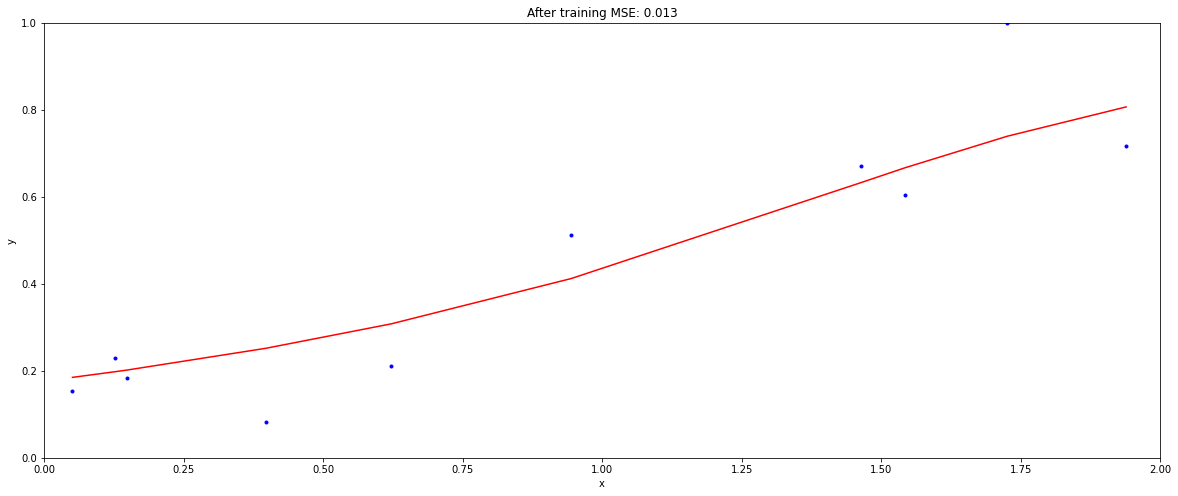

In [7]:
y_pred = model(X_valid)

valid_mse = round(mean_squared_error(y_valid, y_pred), 3)

plt.figure(figsize=(20, 8))
y_pred_sq = np.squeeze(y_pred)
X_valid_sq = np.squeeze(X_valid)

plt.plot(X_valid_sq, y_pred_sq, 'r-')
# plt.plot(X_valid_sq, y_pred_sq, linestyle='solid',color='red')
plt.plot(X_valid, y_valid, 'b.')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'After training MSE: {valid_mse}')
plt.axis([0,2,0,1])